# Topic Modeling with BERT

Objective:

The task is to classify sentences/documents into predefined topics using NLP techniques. We approach this as a <b>topic classification</b> problem, where each document is assigned a label corresponding to a topic (e.g. "sports", "movies").

Why it's important:

Topic modeling helps in organizing, summarizing, and understanding large collections of documents, improving tasks such as content filtering, recommendation systems, and digital archiving.

Note: Uncomment the appropriate cells for importing data depending on whether you are using <b>VS Code</b> or <b>Google Colab</b>.

In [1]:
# Set up
!pip install simpletransformers

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt
import seaborn as sn

## Data Loading & Preprocessing



In [3]:
labels = {0: 'movie', 1: 'sports', 2: 'books'}

In [4]:
# Google Drive link
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# ONLY FOR Google Colab
df = pd.read_csv('/content/drive/MyDrive/train.csv')
df.head()

,sentence,sentiment,topic
0,This book was the very first bookmobile book I...,positive,book
1,"When I read the description for this book, I c...",negative,book
2,I just had to edit this review. This book is a...,positive,book
3,I don't normally buy 'mystery' novels because ...,positive,book
4,"This isn't the kind of book I normally read, a...",positive,book


In [6]:
# ONLY for VSC
# df = pd.read_csv('train.csv')

# df.head()

In [7]:
# Check for null or non-string text values
print(df['sentence'].isnull().sum())
print(df['sentence'].apply(lambda x: isinstance(x, str)).value_counts())


0
sentence
True    49524
Name: count, dtype: int64


In [8]:
df['topic'].value_counts()

,count
topic,
sports,22524
movie,15000
book,12000


In [9]:
sample_size = 12000

# sampling each dataset in a fair way by using our set sample size of 12000
df_balanced = pd.concat([
    df[df['topic'] == 'sports'].sample(sample_size, random_state=42),
    df[df['topic'] == 'movie'].sample(sample_size, random_state=42),
    df[df['topic'] == 'book'].sample(sample_size, random_state=42)  #samples all values of book dataset
])

# shuffling final dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# applying label encoding
df_balanced['label'] = df_balanced['topic'].apply(lambda x: 0 if x == 'movie' else 1 if x == 'sports' else 2)

df = df_balanced
df.head()

,sentence,sentiment,topic,label
0,This book was the very first bookmobile book I...,positive,book,2
1,"When I read the description for this book, I c...",negative,book,2
2,I just had to edit this review. This book is a...,positive,book,2
3,I don't normally buy 'mystery' novels because ...,positive,book,2
4,"This isn't the kind of book I normally read, a...",positive,book,2


In [10]:
df['label'].value_counts()

,count
label,
1,22524
0,15000
2,12000


In [11]:
print(df['label'].unique())
print(df['label'].value_counts())
print(df['label'].dtype)


[2 1 0]
label
1    22524
0    15000
2    12000
Name: count, dtype: int64
int64


### Train-Validation Split

Use a subset (10%) of the training set as a validation set

In [12]:
from sklearn.model_selection import train_test_split

# Ensure the DataFrame has only the required columns
selected_df = df[['sentence', 'label']]
selected_df.columns = ['text', 'labels']

# Re-split to get a clean train/dev set
train_df, dev_df = train_test_split(
    selected_df,
    test_size=0.1,
    stratify=selected_df['labels'],
    random_state=42
)


In [13]:
print(train_df.head())
print(train_df.dtypes)

                                                sentence  label
36608  I attended the premier last night. The movie s...      0
21157  What offside???\n#WorldcupQatar2022 #WorldCup2022      1
17680  Only issue with Ecuador so far, they’ve been a...      1
27783                Loving this opening!! #WorldCup2022      1
21986                        The fix is in #WorldCup2022      1
sentence    object
label        int64
dtype: object


In [14]:
print(dev_df.head())
print(dev_df.dtypes)

                                                sentence  label
33816  #WorldCup2022 If you're visiting #Qatar, pleas...      1
9678   I have read the mind reader series that Lori w...      2
21745  VAR to help Qatar #WorldCup2022 https://t.co/o...      1
42467  R Balki tries to tell you a story that had bee...      0
31861  🗣 A message from the #NUFC striker \n\n#Eng #W...      1
sentence    object
label        int64
dtype: object


### Model Configuration and Initialization

In [ ]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=1 # number of epochs (5,10,20)
model_args.train_batch_size=4 # batch size
model_args.learning_rate=4e-6 # learning rate (4e-6 or 2e-6)
model_args.max_seq_length=256 # maximum sequence length, up to 512 (256, 384, 512)
# Note! Increasing max_seq_len may provide better performance, but training time will increase.
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

With this configuration, the training will terminate if the eval_loss on the evaluation data does not improve upon the best eval_lostt by at least 0.01 for 2 consecutive evaluations.

An evaluation will occur once for every 32 training steps

In [ ]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(train_df) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch))

Model Architecture: Electra 

https://huggingface.co/docs/transformers/en/model_doc/electra

Reasons:
1. More Efficient Pretraining Objective
- ELECTRA uses a more sample-efficient approach called Replaced Token Detection (RTD). Instead of masking, ELECTRA replaces some tokens with plausible alternatives and trains the model to detect if a token is "real" or "fake". This leads to better learning from the same amount of data and faster convergence.

2. Smaller Yet More Powerful
- ELECTRA achieves BERT-like or better performance with fewer parameters.

3. Faster and Cheaper to Train
- ELECTRA converges in fewer steps than BERT. It offers better compute efficiency while maintaining or improving downstream performance.

<b>However</b>, ELECTRA’s architecture is more complex and less interpretable than BERT’s, and it may require careful tuning when fine-tuning on downstream tasks. Additionally, since ELECTRA does not use masking, it is not directly compatible with some techniques designed specifically for masked language models like BERT.



In [ ]:
# Loading the pre-trained model
# model = ClassificationModel('bert', 'bert-base-cased', num_labels=4, args=model_args, use_cuda=True) # CUDA is enabled

import torch
model = ClassificationModel(
    # model_type="distilbert",
    # model_name="distilbert-base-uncased",
    model_type="electra",
    model_name="google/electra-small-discriminator",
    num_labels=3,
    args=model_args,
    use_cuda=torch.cuda.is_available()
)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
print(str(model.args).replace(',', '\n')) # model args

### Training

In [35]:
_, history = model.train_model(train_df, eval_df=dev_df)

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/1393 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


### Evaluation & Results

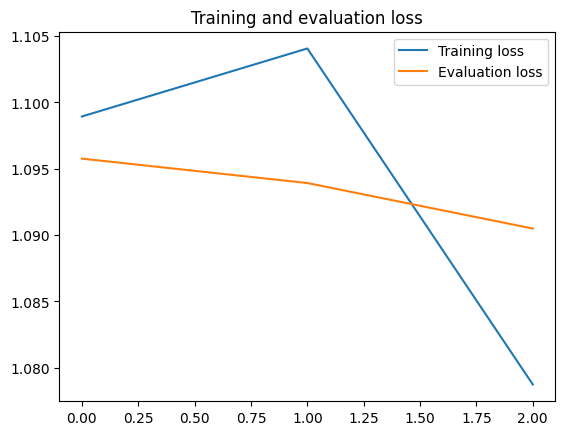

In [22]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [36]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev_df)
result

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


{'mcc': np.float64(0.9874597973544699), 'eval_loss': 0.3869761162996292}

In [37]:
predicted, probabilities = model.predict(dev_df.text.to_list())
dev_df['predicted'] = predicted

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [38]:
# Result (note: your result can be different due to randomness in operations)
print(classification_report(dev_df['labels'], dev_df['predicted']))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1500
           1       1.00      1.00      1.00      2253
           2       0.98      0.99      0.98      1200

    accuracy                           0.99      4953
   macro avg       0.99      0.99      0.99      4953
weighted avg       0.99      0.99      0.99      4953



### Testing using test set


In [ ]:
# Importing test set
# Google Colab
unseen_df = pd.read_csv('/content/drive/MyDrive/sentiment-topic-test.tsv', sep='\t')
unseen_df.head()

,sentence_id,sentence,sentiment,topic
0,0,The stadium was alive with the roar of the cro...,positive,sports
1,1,That last-minute goal had me jumping out of my...,positive,sports
2,2,I couldn’t put the book down; it swept me into...,positive,book
3,3,"The story had its moments, though some parts f...",neutral,book
4,4,"I enjoyed the way the timelines shifted, even ...",neutral,book


In [40]:
# VSC
# unseen_df = pd.read_csv('sentiment-topic-test.tsv', sep='\t')
# unseen_df.head

In [41]:
unseen_df['label'] = unseen_df['topic'].apply(lambda x: 0 if x == 'movie' else 1 if x == 'sports' else 2 if x == 'book' else -1)
unseen_df.head()

,sentence_id,sentence,sentiment,topic,label
0,0,The stadium was alive with the roar of the cro...,positive,sports,1
1,1,That last-minute goal had me jumping out of my...,positive,sports,1
2,2,I couldn’t put the book down; it swept me into...,positive,book,2
3,3,"The story had its moments, though some parts f...",neutral,book,2
4,4,"I enjoyed the way the timelines shifted, even ...",neutral,book,2


In [42]:
print(unseen_df['label'].unique())  # Should be [0, 1, 2]

[1 2 0]


In [43]:
predicted, probabilities = model.predict(unseen_df['sentence'].tolist())
unseen_df['predicted'] = predicted

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.00      0.00      0.00         6
           2       0.35      1.00      0.52         6

    accuracy                           0.39        18
   macro avg       0.45      0.39      0.27        18
weighted avg       0.45      0.39      0.27        18



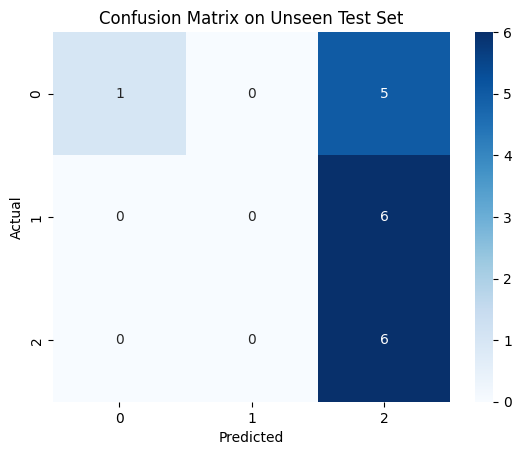

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print(classification_report(unseen_df['label'], unseen_df['predicted']))

# Confusion matrix
cm = confusion_matrix(unseen_df['label'], unseen_df['predicted'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Unseen Test Set')
plt.show()